<h1 style="text-align: center; font-weight: bold; font-size: 36px;">Character Level MLP - Torch Autograd</h1>

# Introduction

Let's create a **bigram** model by **gradient descent** - a single linear layer pseudo neural network.

Inspired by Karpathy [Neural Networks: Zero-to-Hero](https://github.com/karpathy/nn-zero-to-hero). 
We are using the same [names.txt](https://github.com/karpathy/makemore/blob/master/names.txt) as in Zero to Hero so we can compare results.

References:

- [Bengio et al. 2003 MLP language model paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

# Imports

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Build the Dataset

In [16]:
with open('../data/names.txt', 'r') as f:
    names = f.read().splitlines()
letters = sorted(list(set(''.join(names))))
letters = ['.'] + letters

In [17]:
class Tokenizer:
    def __init__(self, vocab):
        assert isinstance(vocab, list)
        assert all(isinstance(v, str) for v in vocab)
        assert all(len(v) == 1 for v in vocab)
        self.stoi = {ch: i for i, ch in enumerate(vocab)}
        self.itos = {i: ch for i, ch in enumerate(vocab)}

    def encode(self, text):
        return [self.stoi[s] for s in text]

    def decode(self, sequence):
        assert isinstance(sequence, torch.Tensor)
        assert sequence.ndim in [0, 1]
        if sequence.ndim == 0:
            return self.itos[sequence.item()]  # one char
        else:
            return ''.join([self.itos[i.item()] for i in sequence])

In [19]:
blok_size = 3  # context length

X, Y = [], []  # inputs and targets

tok = Tokenizer(vocab=letters)
for name in names:
    name = '.'*blok_size + name + '.'  # add start/stop tokens '..emma.'
    for i in range(len(name) - blok_size):
        X.append(tok.encode(name[i:i+blok_size]))
        Y.append(tok.encode(name[i+blok_size])[0])  # [0] to keep Y 1d tensor

X = torch.tensor(X)
Y = torch.tensor(Y)

In [20]:
def train_model(num_epochs, lr):
    """Train. lr may be a list with length equal to num_epochs"""

    if isinstance(lr, (int, float)):
        lr = [lr] * num_epochs
    assert len(lr) == num_epochs


    losses = []

    # Init Layers
    torch.manual_seed(42)
    C = torch.randn((27, 2), requires_grad=True)     # n_vocab, n_emb (embeddings)
    W1 = torch.randn((6, 100), requires_grad=True)   # n_seq+n_emb, n_hid1
    b1 = torch.randn((1, 100), requires_grad=True)   # 1, n_hid1
    W2 = torch.randn((100, 27), requires_grad=True)  # n_hid1, n_out
    b2 = torch.randn((1, 27), requires_grad=True)    # 1, n_out
    params = [C, W1, b1, W2, b2]

    for i in range(num_epochs):

        # Random mini batch
        batch_indices = torch.randint(0, X.shape[0], (32,))
        x_batch = X[batch_indices]
        y_batch = Y[batch_indices]

        # Forward Pass
        emb = C[x_batch]                            # n_batch, n_seq, n_emb
        h1 = torch.tanh(emb.view(-1, 6) @ W1 + b1)  # n_batch, n_hid1
        logits = h1 @ W2 + b2                       # n_batch, n_vocab
        loss = F.cross_entropy(logits, y_batch)

        losses.append(loss.item())

        # Backward Pass
        for p in params:
            p.grad = None
        loss.backward()
        for p in params:
            p.data += -lr[i] * p.grad

    return losses

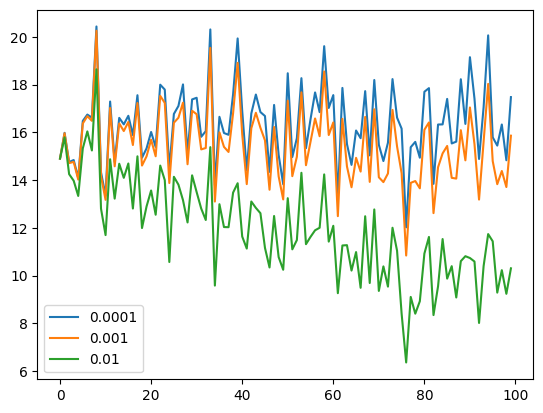

In [21]:
losses = {}
losses["0.0001"] = train_model(100, 0.0001)  # not decreasing
losses["0.001"] = train_model(100, 0.001)  # not decreasing
losses["0.01"] = train_model(100, 0.01)  # not decreasing

for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()
# 0.001 seems to be lower bound

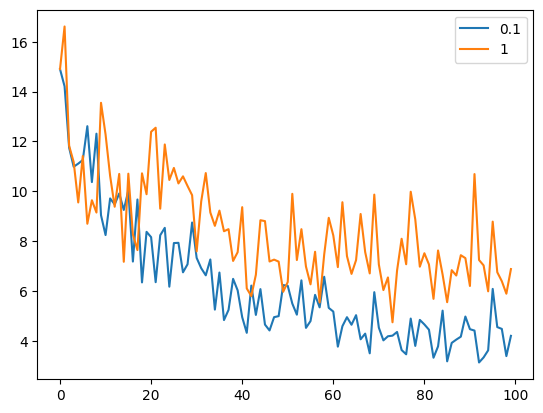

In [22]:
losses = {}
losses["0.1"] = train_model(100, 0.1)
losses["1"] = train_model(100, 1)

for k, v in losses.items():
    plt.plot(v, label=k)
plt.legend()
plt.show()
# 1.0 seems to be upper bound

In [23]:
lr_exponents = torch.linspace(-3, 0, 1000)  # from 10**-3=0.001 to 10**0=1
lr_list = 10**lr_exponents

losses = train_model(1000, lr_list)

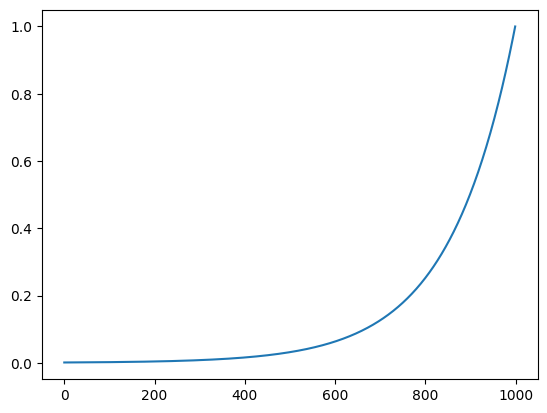

In [24]:
plt.plot(lr_list)
plt.show()

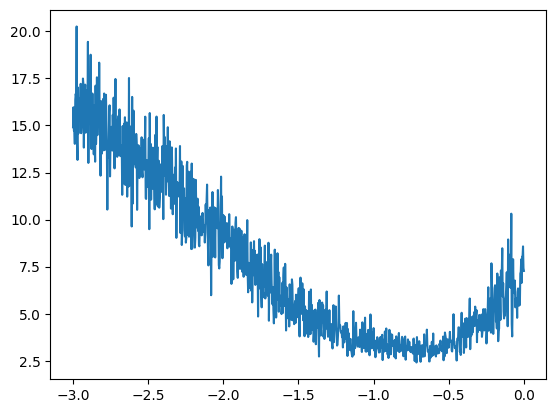

In [25]:
plt.plot(lr_exponents, losses)
plt.show()

From the above graph, we conclude that `lr_exponent==-1.0` is good, which corresponds to `lr=0.1`